# Modelo de Hodgkin y Huxley

# Simulación del Modelo de Hodgkin-Huxley

Este notebook tiene como objetivo simular el modelo clásico de Hodgkin-Huxley para una neurona y observar de manera numérica cómo se comporta una célula antes diferentes protocolos de simulación. El modelo de Hodgkin-Huxley describe la dinámica de la membrana neuronal utilizando ecuaciones diferenciales que capturan la evolución de variables de estado como el potencial de membrana y las conductancias de los canales iónicos.

### Modelo de Hodgkin-Huxley

Las ecuaciones que describen el modelo son las siguientes:

$
C_m \frac{dV}{dt} = I_{ext} - (I_{Na} + I_K + I_L)
$

donde:
- $ V $ es el potencial de membrana,
- $ C_m $ es la capacidad de la membrana,
- $ I_{ext} $ es la corriente externa aplicada,
- $ I_{Na} $, $ I_K $ y $ I_L $ son las corrientes de sodio, potasio y fuga, respectivamente.

### Corrientes iónicas

Las corrientes $ I_{Na} $, $ I_K $ y $ I_L $ se modelan de la siguiente manera:

$
I_{Na} = \bar{g}_{Na} m^3 h (V - E_{Na})
$
$
I_K = \bar{g}_K n^4 (V - E_K)
$
$
I_L = \bar{g}_L (V - E_L)
$

donde $ \bar{g} $ son las conductancias máximas, $ E $ son los potenciales de equilibrio y $ m $, $ h $, $ n $ son variables de compuerta.

### Variables de compuerta

Las variables $ m $, $ h $, y $ n $ siguen ecuaciones del tipo:

$
\frac{dx}{dt} = \alpha_x (1 - x) - \beta_x x
$

donde $ x $ puede ser $ m $, $ h $ o $ n $, y $ \alpha_x $ y $ \beta_x $ son funciones del potencial de membrana $ V $.

Para este ejercicio use las siguientes definiciones de $\alpha_x$ y $\beta_x$:

$$
\alpha_n = \frac{0.01(V+55)}{1-exp(-(V+55)/10)}
$$

$$
\beta_n = 0.125exp(-(V+65)/80)
$$


$$
\alpha_m = \frac{0.1(V+40)}{1-exp(-(V+40)/10)}
$$

$$
\beta_m = 4exp(-(V+65)/18)
$$

$$
\alpha_h = 0.07exp(-(V+65)/20)
$$

$$
\beta_h = \frac{1}{1+exp(-(V+35)/10)}
$$

así como $C_m = 1\mu/cm^2$, $\bar{g}_{Na} = 120ms/cm^2$, $\bar{g}_K = 36ms/cm^2$, $\bar{g}_L = 0.3 ms/cm^2$, $E_{Na} = 50mV$, $E_K = -77mV$, $E_L = -50mV$.


### Ejercicio 1:
Use un protocolo de estimulación que como el que se muestra en la figura a continuación y reconstruya el mismo gráfico. El protocolo de estimulación consiste en pulsos de 5 milisengundos de amplitud 5 el primero y 25 el segundo. Tenga en cuenta que este gráfico tiene parámetros ligeramente diferentes que hace que el potencial de membrana este movido a $V_{rest} = 0$.

![HH_excercise.png](attachment:HH_excercise.png)

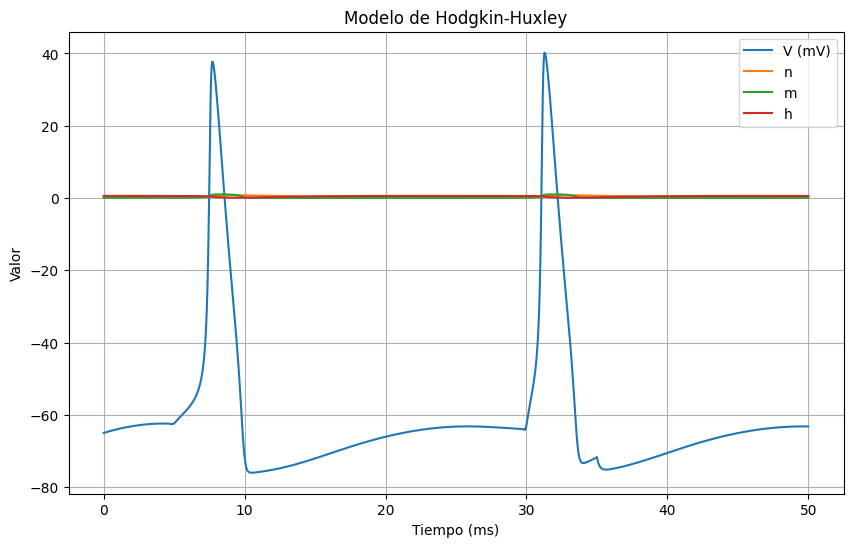

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# --- Parámetros del modelo ---
Cm = 1      # Capacitancia de membrana (μF/cm^2)
gNa = 120   # Conductancia máxima del canal de sodio (mS/cm^2)
gK = 36     # Conductancia máxima del canal de potasio (mS/cm^2)
gL = 0.3    # Conductancia de fuga (mS/cm^2)

ENa = 50    # Potencial de equilibrio del sodio (mV)
Ek = -77    # Potencial de equilibrio del potasio (mV)
EL = -50    # Potencial de equilibrio de fuga (mV)

pulsos = [5, 15]           # Tiempos de inicio de cada pulso (ms)
amplitud_pulso = [5, 25]        # Amplitud fija para cada pulso (μA/cm^2)
pulso_duracion = 5         # Duración de cada pulso (ms)

# --- Funciones de transición de compuertas ---
def alpha_n(V): return (0.01 * (V + 55)) / (1 - np.exp(-(V + 55) / 10))
def beta_n(V):  return 0.125 * np.exp(-(V + 65) / 80)
def alpha_m(V): return (0.1 * (V + 40)) / (1 - np.exp(-(V + 40) / 10))
def beta_m(V):  return 4 * np.exp(-(V + 65) / 18)
def alpha_h(V): return 0.07 * np.exp(-(V + 65) / 20)
def beta_h(V):  return 1 / (1 + np.exp(-(V + 35) / 10))

def n_inf(V): return alpha_n(V) / (alpha_n(V) + beta_n(V))
def m_inf(V): return alpha_m(V) / (alpha_m(V) + beta_m(V))
def h_inf(V): return alpha_h(V) / (alpha_h(V) + beta_h(V))

def tau_n(V): return 1 / (alpha_n(V) + beta_n(V))
def tau_m(V): return 1 / (alpha_m(V) + beta_m(V))
def tau_h(V): return 1 / (alpha_h(V) + beta_h(V))

# --- Corriente externa aplicada
def I_ext_func(t):
     for inicio, amp in zip(pulsos, amplitud_pulso):
        if inicio <= t <= inicio + pulso_duracion:
            return amp
     return 0.0

# --- Ecuaciones diferenciales del modelo ---
def hodgkin_huxley(t, y):
    V, n, m, h = y

    # Corrientes iónicas
    INa = gNa * (m**3) * h * (V - ENa)
    IK = gK * (n**4) * (V - Ek)
    IL = gL * (V - EL)

    # Derivadas
    I = I_ext_func(t)    # corriente que depende del tiempo
    dVdt = (I - INa - IK - IL) / Cm
    dndt = (n_inf(V) - n) / tau_n(V)
    dmdt = (m_inf(V) - m) / tau_m(V)
    dhdt = (h_inf(V) - h) / tau_h(V)

    return [dVdt, dndt, dmdt, dhdt]

# --- Condiciones iniciales ---
V0 = -65  # mV
y0 = [V0, n_inf(V0), m_inf(V0), h_inf(V0)]

# --- Tiempo de simulación ---
t_span = (0, 50)  # ms
t_eval = np.linspace(t_span[0], t_span[1], 5000)

# --- Resolver el sistema ---
sol = solve_ivp(
    fun=hodgkin_huxley,
    t_span=t_span,
    y0=y0,
    t_eval=t_eval,
    method='RK45'
)

# --- Graficar resultados ---
plt.figure(figsize=(10, 6))
plt.plot(sol.t, sol.y[0], label='V (mV)')
plt.plot(sol.t, sol.y[1], label='n')
plt.plot(sol.t, sol.y[2], label='m')
plt.plot(sol.t, sol.y[3], label='h')
plt.xlabel('Tiempo (ms)')
plt.ylabel('Valor')
plt.title('Modelo de Hodgkin-Huxley')
plt.legend()
plt.grid(True)
plt.show()


## Ejercicio 2:

Repita el ejercicio anterior pero ahora aplique otro pulso de amplitud 25$\mu A/cm^2$ a los 15ms y responda las siguientes preguntas:

1. Qué esperaría observar?
2. Qué observa en cambio esta vez?
3. Investigue por qué se da el periodo refractario